#  Pokec Network Study (sampled version)

We’re going to:
1. Load the giant Pokec friendship graph  
2. Extract a connected 10 000-node subgraph using BFS sampling  
3. Load and clean user attributes  
4. Attach those attributes to the sampled graph  
5. Visualize it and confirm it behaves like the full network  


In [1]:
# ==================================
#  Imports
# ==================================
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
plt.style.use("seaborn-v0_8")


## 1️ Load a partial graph and sample a connected subgraph
The full Pokec dataset has 1.6 M nodes and 30 M edges — too heavy.
We load the first few hundred thousand edges, then extract a BFS subgraph (~10 k nodes).


In [16]:
def load_partial_graph(path, max_edges=500_000):
    G = nx.Graph()
    with open(path) as f:
        for i, line in enumerate(f):
            if i >= max_edges:
                break
            try:
                u, v = map(int, line.strip().split('\t'))
                G.add_edge(u, v)
            except:
                continue
    return G

print("⏳ Loading part of Pokec edges...")
G = load_partial_graph("datasetfb/soc-pokec-relationships.txt", max_edges=500_000)
print(f"✅ Partial graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# BFS sample around one random node, deeper exploration
start = random.choice(list(G.nodes()))
sub_nodes = list(nx.bfs_tree(G, start, depth_limit=3).nodes())  # ⬅️ augmenté à 3
H = G.subgraph(sub_nodes).copy()

# Si le graphe est encore trop petit, essaie depth_limit=4
if H.number_of_nodes() < 1000:
    print(f"Too small ({H.number_of_nodes()} nodes), trying deeper BFS...")
    sub_nodes = list(nx.bfs_tree(G, start, depth_limit=4).nodes())
    H = G.subgraph(sub_nodes).copy()

print(f"✅ BFS subgraph: {H.number_of_nodes()} nodes, {H.number_of_edges()} edges")



⏳ Loading part of Pokec edges...
✅ Partial graph: 195174 nodes, 464082 edges
Too small (169 nodes), trying deeper BFS...
✅ BFS subgraph: 24303 nodes, 53486 edges


## 2️ Load and clean user features
We’ll keep only interpretable columns: `user_id`, `gender`, `age`, `region`, `smoker`, `drinker`.


In [17]:
profiles = pd.read_csv("datasetfb/soc-pokec-profiles.txt", sep='\t', header=None, low_memory=False)

cols = [
    "user_id","public","completion","gender","region",
    "last_login","registration","age","body","work_field",
    "languages","hobbies","interests","music","movies",
    "religion","cars","politics","looking_for","smoker","drinker"
]
profiles.columns = cols + list(range(len(cols), profiles.shape[1]))

df = profiles[["user_id","gender","age","region","smoker","drinker"]].copy()
df = df.dropna(subset=["user_id"])
df["user_id"] = df["user_id"].astype(int)
df["gender"] = df["gender"].map({1.0:"male", 0.0:"female"})
df["age"] = pd.to_numeric(df["age"], errors="coerce")
df["region"] = df["region"].astype(str).str.split(",").str[0]
df = df.dropna(subset=["gender","age","region"])


print(" Cleaned features sample:")
print(df.head())


 Cleaned features sample:
   user_id  gender   age                region  \
0        1    male  26.0         zilinsky kraj   
1        2  female   0.0         zilinsky kraj   
2       16    male  23.0         zilinsky kraj   
3        3    male  29.0     bratislavsky kraj   
4        4  female  26.0  banskobystricky kraj   

                                              smoker                drinker  
0                                                NaN                    NaN  
1  zakladne, ale som uz na strednej skole dufam z...  cierna, modra, ruzova  
2                      coskoro 24.5 alebo 31.9    :d   biela, modra, zelena  
3                                                NaN          cierna, modra  
4                                                NaN                    NaN  


## 3️ Simplify messy text attributes (smoker, drinker)
Pokec users often wrote anything in Slovak (“nepijem”, “pijem”, “modrá”), so we reduce to simple categories.


In [19]:
def simplify_text(val):
    if not isinstance(val, str):
        return "unknown"
    val = val.lower()
    if any(k in val for k in ["ne", "nie", "vobec"]):
        return "no"
    if any(k in val for k in ["ano", "áno", "hej", "pijem", "obcas", "občas"]):
        return "yes"
    return "unknown"

df["smoker_clean"] = df["smoker"].apply(simplify_text)
df["drinker_clean"] = df["drinker"].apply(simplify_text)
df["age"] = df["age"].replace(0, np.nan)
df["age_group"] = pd.cut(df["age"], bins=[0,18,25,35,50,80],
                         labels=["<18","18-25","25-35","35-50","50+"],
                         include_lowest=True)

print(" Cleaned feature sample:")
print(df.head())


 Cleaned feature sample:
   user_id  gender   age                region  \
0        1    male  26.0         zilinsky kraj   
1        2  female   NaN         zilinsky kraj   
2       16    male  23.0         zilinsky kraj   
3        3    male  29.0     bratislavsky kraj   
4        4  female  26.0  banskobystricky kraj   

                                              smoker                drinker  \
0                                                NaN                    NaN   
1  zakladne, ale som uz na strednej skole dufam z...  cierna, modra, ruzova   
2                      coskoro 24.5 alebo 31.9    :d   biela, modra, zelena   
3                                                NaN          cierna, modra   
4                                                NaN                    NaN   

  smoker_clean drinker_clean age_group  
0      unknown       unknown     25-35  
1           no       unknown       NaN  
2      unknown       unknown     18-25  
3      unknown       unknown     25

## 4️ Attach cleaned features to the subgraph
We'll keep only users that appear in the graph and assign their attributes.


In [22]:
feat = df[["user_id","gender","age","age_group","region","smoker_clean","drinker_clean"]]
feat = feat[feat["user_id"].isin(H.nodes())]
attrs = feat.set_index("user_id").to_dict("index")
nx.set_node_attributes(H, attrs)
print(f" {len(feat)} attributes attached to graph nodes.")


 24303 attributes attached to graph nodes.


## 5️ Basic structural metrics
Let’s compute degree and clustering to verify the graph behaves like a real social network.


In [24]:
deg_mean = np.mean([d for _, d in H.degree()])
clust_mean = nx.average_clustering(H)
print(f"Average degree: {deg_mean:.2f}")
print(f"Average clustering coefficient: {clust_mean:.4f}")


Average degree: 4.40
Average clustering coefficient: 0.2743


## 6️ Visualization (color by region)


Visualizing connected subgraph: 6698 nodes, 7512 edges


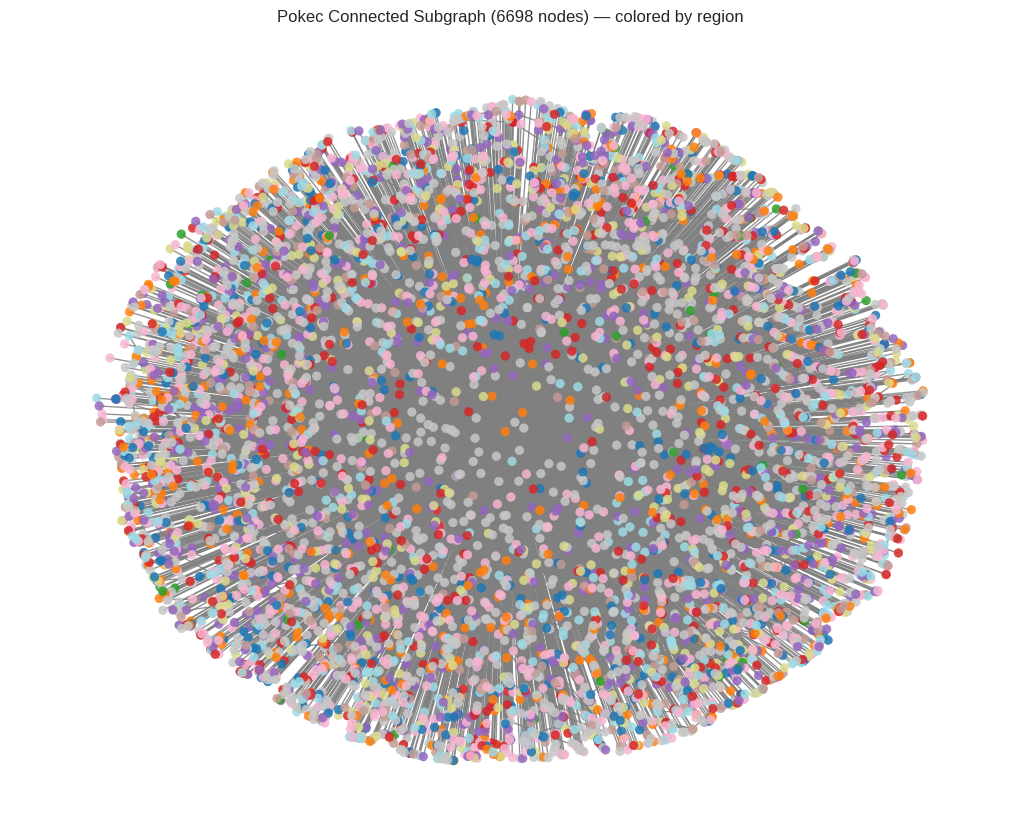

In [34]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Pick a random starting node
start = random.choice(list(H.nodes()))

# Get neighbors up to 2 hops away
connected_nodes = list(nx.single_source_shortest_path_length(H, start, cutoff=2).keys())
S = H.subgraph(connected_nodes).copy()

print(f"Visualizing connected subgraph: {S.number_of_nodes()} nodes, {S.number_of_edges()} edges")

# Layout + visualization
pos = nx.spring_layout(S, seed=42, iterations=30)

regions = [S.nodes[n].get("region", "unknown") for n in S.nodes()]
unique_regions = sorted(set(regions))
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_regions)))
color_dict = {r: colors[i % 20] for i, r in enumerate(unique_regions)}
node_colors = [color_dict[S.nodes[n].get("region", "unknown")] for n in S.nodes()]

plt.figure(figsize=(10, 8))
nx.draw(
    S, pos,
    node_color=node_colors,
    node_size=40,
    edge_color="gray",
    with_labels=False,
    alpha=0.85
)
plt.title(f"Pokec Connected Subgraph ({S.number_of_nodes()} nodes) — colored by region")
plt.show()


## 7️ Homophily analysis
We measure how similar connected users are in gender, age, and region.


In [35]:
# Gender homophily (-1 = mixed, +1 = same-gender)
assort_gender = nx.attribute_assortativity_coefficient(H, "gender")

# Age correlation
edges = [(H.nodes[u].get("age"), H.nodes[v].get("age"))
         for u, v in H.edges() if "age" in H.nodes[u] and "age" in H.nodes[v]]
ages_u, ages_v = zip(*edges)
corr_age = np.corrcoef(ages_u, ages_v)[0,1]

# Region homophily
assort_region = nx.attribute_assortativity_coefficient(H, "region")

print(f"Gender assortativity: {assort_gender:.3f}")
print(f"Age correlation across edges: {corr_age:.3f}")
print(f"Region assortativity: {assort_region:.3f}")


Gender assortativity: -0.180
Age correlation across edges: nan
Region assortativity: 0.207
